<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/model0/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random



# 2. Preprocess data

Datasets:
- `smallset_onesize` [DEPRECATED - DO NOT USE]
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB
- `largeset_multisize` [USE THIS ONE]
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 18329 color/gray pairs. (actually 18328 - had to delete photo 2507 due to strange resolution issues)
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)
  - 401 MB



In [3]:


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255
    arr.append(img_to_array(img))

  return arr


In [6]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/color')

100%|██████████| 18328/18328 [00:08<00:00, 2246.49it/s]


In [7]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/gray')

100%|██████████| 18328/18328 [00:07<00:00, 2564.89it/s]


In [8]:
# Make a tensor list of reformatted images (based on Stuarts's axis swap)
gray_tensors = []

for image in gray_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    gray_tensors.append(t)

color_tensors = []

for image in color_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    color_tensors.append(t)

# 3. Model
Toy model generated below:

In [9]:
# prompt: pytorch colourization autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()



Train toy model:

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(gray_arr)):
        if (gray_tensors[i].size() != torch.Size([3, 128, 128])):
          continue # turns out there are some non-square images (like maybe 5 or 10 total) in the original smallset dataset, and so they're here too... temporary fix

        inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
        targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(gray_arr)))

print('Finished Training')

[1] loss: 0.010
Finished Training


# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

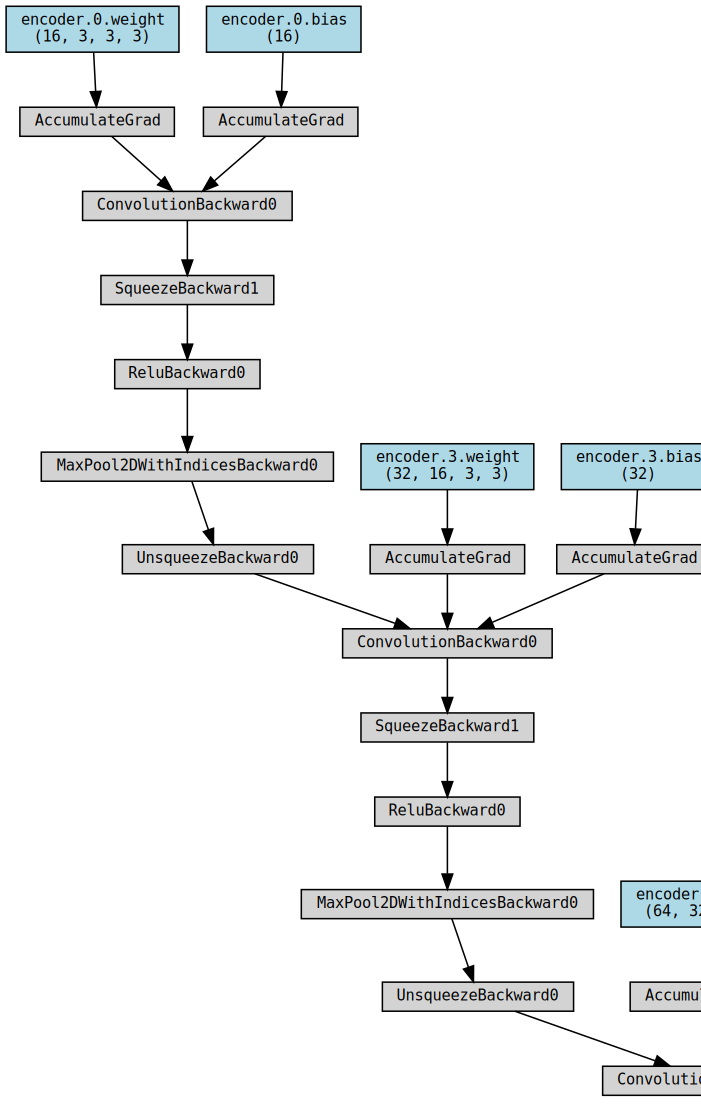

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

In [12]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/model0/decoder_weights')

In [13]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/model0/encoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [29]:
!cd CPSC-440-Project
!pwd
!ls
!cd sample_data
!pwd

/content
CPSC-440-Project  sample_data
/content


In [30]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!